<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/Pose2SLAMExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose2 SLAM

A simple way to do Simultaneous Localization and Mapping is to just fuse **relative pose measurements** between successive robot poses. This landmark-less SLAM variant is often called "Pose SLAM"

In [16]:
%pip -q install gtbook # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math

import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt

In [2]:
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(
    gtsam.Point3(0.2, 0.2, 0.1))


1. Create a factor graph container and add factors to it


In [3]:
graph = gtsam.NonlinearFactorGraph()

2a. Add a prior on the first pose, setting it to the origin

A prior factor consists of a mean and a noise ODOMETRY_NOISE (covariance matrix)

In [4]:
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))

2b. Add odometry factors
Create odometry (Between) factors between consecutive poses


In [5]:
graph.add(gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2, 0, math.pi / 2),ODOMETRY_NOISE))


2c. Add the loop closure constraint
This factor encodes the fact that we have returned to the same pose. In real
systems, these constraints may be identified in many ways, such as appearance-based
techniques with camera images. We will use another Between Factor to enforce this constraint:


In [6]:
graph.add( gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
print("\nFactor Graph:\n{}".format(graph))


Factor Graph:
NonlinearFactorGraph: size: 6

Factor 0: PriorFactor on 1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.3; 0.3; 0.1];

Factor 1: BetweenFactor(1,2)
  measured:  (2, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 2: BetweenFactor(2,3)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 3: BetweenFactor(3,4)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 4: BetweenFactor(4,5)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 5: BetweenFactor(5,2)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];




3. Create the data structure to hold the initial_estimate estimate to the
solution. For illustrative purposes, these have been deliberately set to incorrect values


In [7]:
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, math.pi / 2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, math.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -math.pi / 2))
print("\nInitial Estimate:\n{}".format(initial_estimate))  


Initial Estimate:
Values with 5 values:
Value 1: (gtsam::Pose2)
(0.5, 0, 0.2)

Value 2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value 3: (gtsam::Pose2)
(4.1, 0.1, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2.1, 2.1, -1.57079633)




4. Optimize the initial values using a Gauss-Newton nonlinear optimizer
The optimizer accepts an optional set of configuration parameters,
controlling things like convergence criteria, the type of linear
system solver to use, and the amount of information displayed during
optimization. We will set a few parameters as a demonstration.


In [8]:
parameters = gtsam.GaussNewtonParams()

Stop iterating once the change in error between steps is less than this value


In [9]:
parameters.setRelativeErrorTol(1e-5)

Do not perform more than N iteration steps


In [10]:
parameters.setMaxIterations(100)

Create the optimizer ...


In [11]:
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)

... and optimize


In [12]:
result = optimizer.optimize()
print("Final Result:\n{}".format(result))


Final Result:
Values with 5 values:
Value 1: (gtsam::Pose2)
(2.29376924e-21, -4.52805219e-20, -8.15716236e-21)

Value 2: (gtsam::Pose2)
(2, -8.1719523e-20, -6.25198652e-21)

Value 3: (gtsam::Pose2)
(4, -3.42174208e-11, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2, 2, -1.57079633)




5. Calculate and print marginal covariances for all variables


In [14]:
marginals = gtsam.Marginals(graph, result)
for i in range(1, 6):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))

X1 covariance:
[[ 9.00000000e-02  5.29468059e-19 -1.56871840e-18]
 [ 5.29468059e-19  9.00000000e-02 -6.39488462e-17]
 [-1.56871840e-18 -6.39488462e-17  1.00000000e-02]]

X2 covariance:
[[ 1.30000000e-01 -3.42668184e-18 -4.70156651e-18]
 [-3.42668184e-18  1.70000000e-01  2.00000000e-02]
 [-4.70156651e-18  2.00000000e-02  2.00000000e-02]]

X3 covariance:
[[ 3.62000000e-01 -3.29295343e-12  6.20000000e-02]
 [-3.29295409e-12  1.62000000e-01 -2.00000000e-03]
 [ 6.20000000e-02 -2.00000000e-03  2.65000000e-02]]

X4 covariance:
[[ 0.268 -0.128  0.048]
 [-0.128  0.378 -0.068]
 [ 0.048 -0.068  0.028]]

X5 covariance:
[[ 0.202   0.036  -0.018 ]
 [ 0.036   0.26   -0.051 ]
 [-0.018  -0.051   0.0265]]



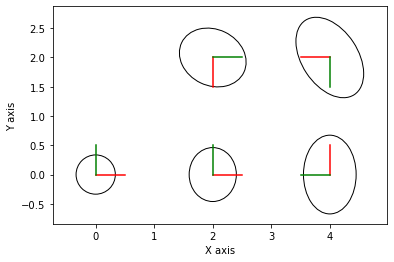

In [15]:
for i in range(1, 6):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5,
                            marginals.marginalCovariance(i))

plt.axis('equal')
plt.show()